'/mnt/c/Users/imcir/Desktop/CIENCIA DATOS/Segundo cuatrimestre/TFM/Código/Modules' already in sys.path
Setup Complete.
Configuration loaded:
  dt: 10
  A_to_B_ratio: 2.2
  reward_B: 1
  abort_penalty: -0.1
  input_noise_sigma: 0.0
  reward_fixation: 0.01
  reward_go_fixation: -0.01
  duration_params: [10, 10, 20, 20]
  actor_hidden_size: 50
  critic_hidden_size: 50
  actor_layers: 1
  critic_layers: 1
  layer_type: GRU_modified
  actor_prob_connection: 0.1
  critic_prob_connection: 1.0
  actor_lr: 0.004
  critic_lr: 0.004
  num_episodes: 35000
  gamma: 1.0
  l2_actor: 0.0001
  l2_critic: 0.0001
  print_interval: 100
  record_history: 1
Creating Padoa-Schioppa environment...
Observation size: 4, Action size: 3
Environment reset. Initial info: {'step': 0, 'epoch': 'fixation', 'juice_LR': ('A', 'B'), 'offer_BA': (1, 2), 'nL': 2, 'nR': 1, 'rL': 4.4, 'rR': 1.0, 'chosen_action': -1, 'choice_time_step': -1, 'is_correct_choice': None, 'A_to_B_ratio': 2.2, 'rewards_cfg': {'fix_step': 0.01, 'go_

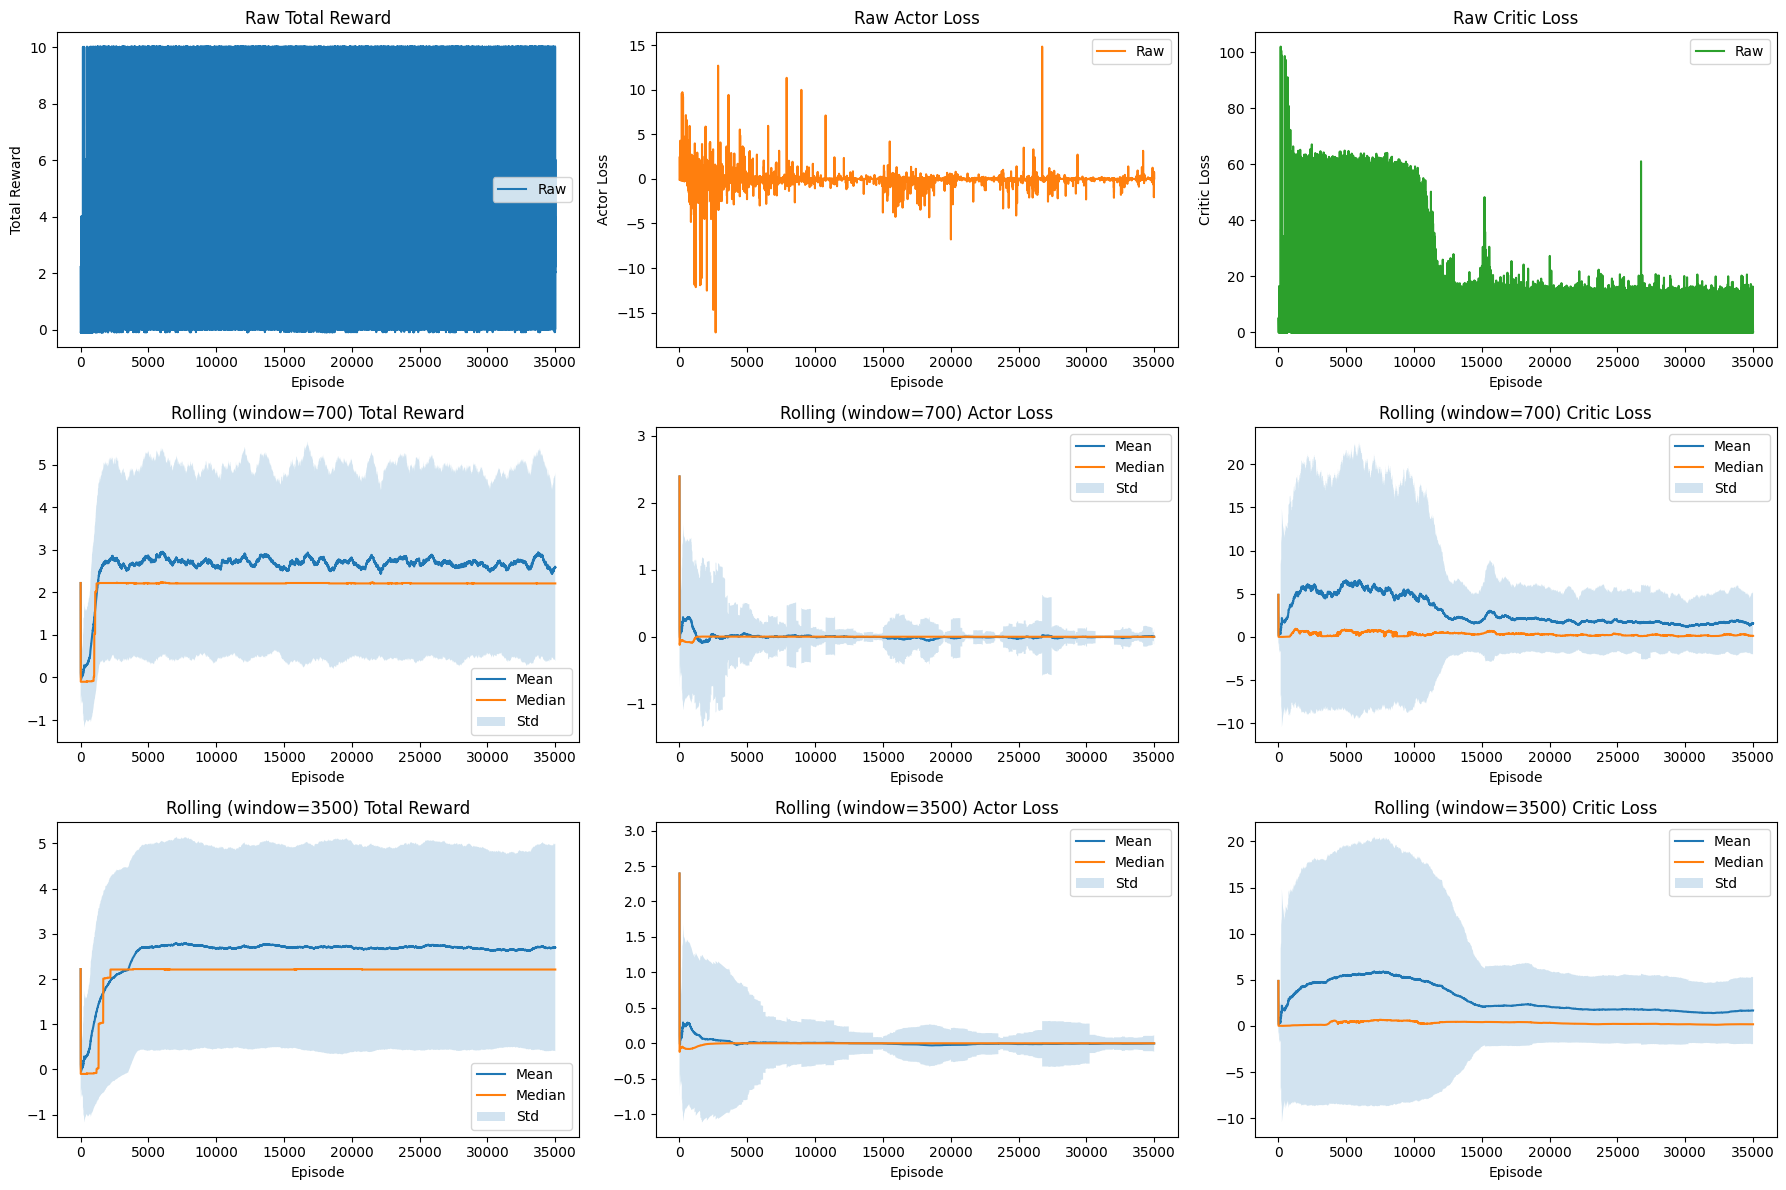

Metrics plot displayed.
Plotting neuron firing rates...


/mnt/c/Users/imcir/Desktop/CIENCIA DATOS/Segundo cuatrimestre/TFM/Código/Modules/helper_functions.py:102: RuntimeWarning: Mean of empty slice
  first_episode = np.nanmean(tensor[:, :, 0], axis=0)
/mnt/c/Users/imcir/Desktop/CIENCIA DATOS/Segundo cuatrimestre/TFM/Código/Modules/helper_functions.py:103: RuntimeWarning: Mean of empty slice
  last_episode = np.nanmean(tensor[:, :, -1], axis=0)


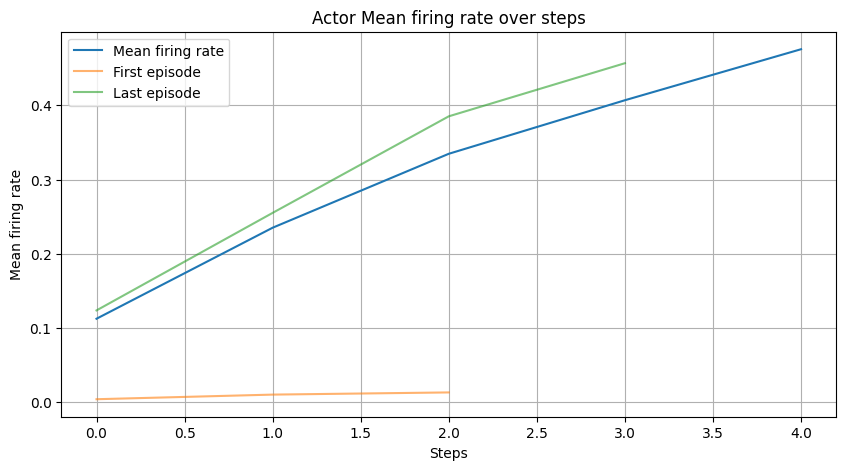

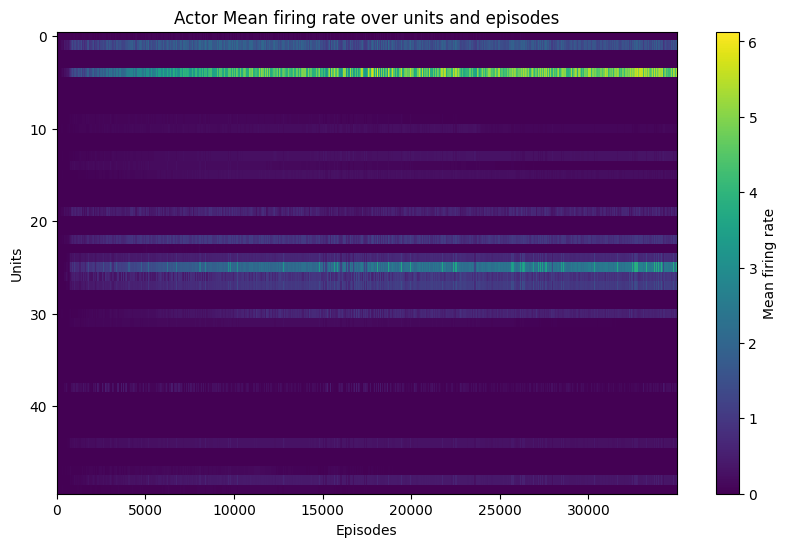

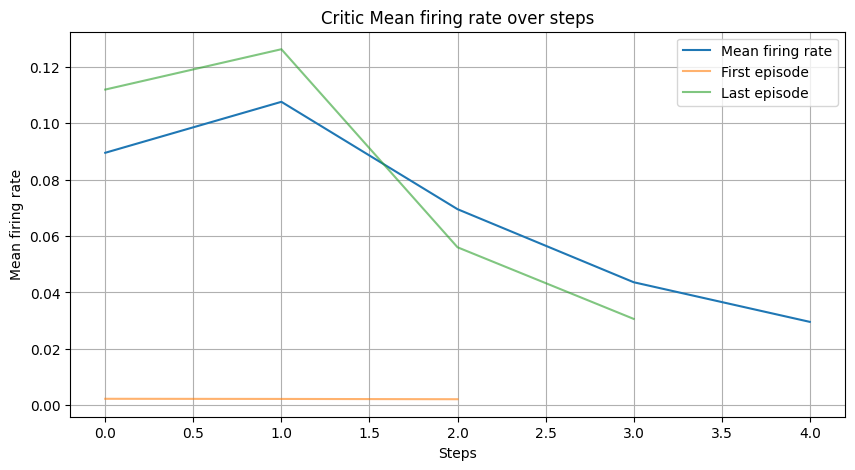

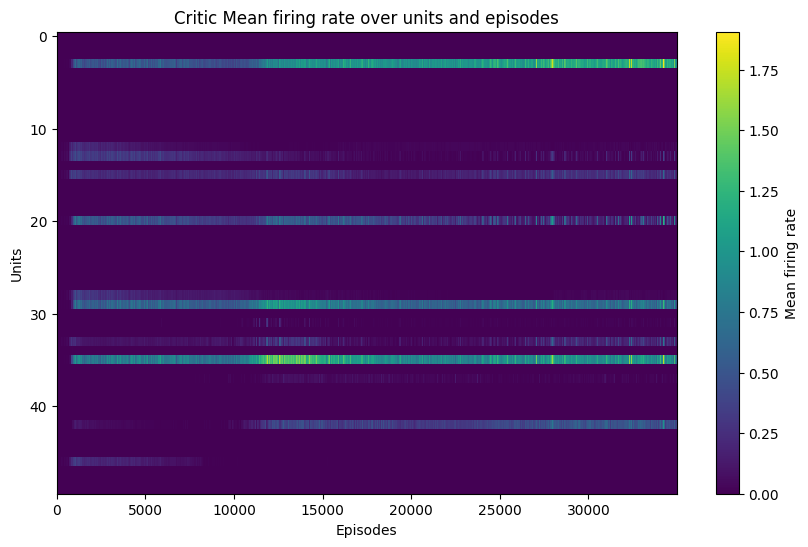

Firing rate plot displayed.

  Plotting Psychometric Curve for this stage...


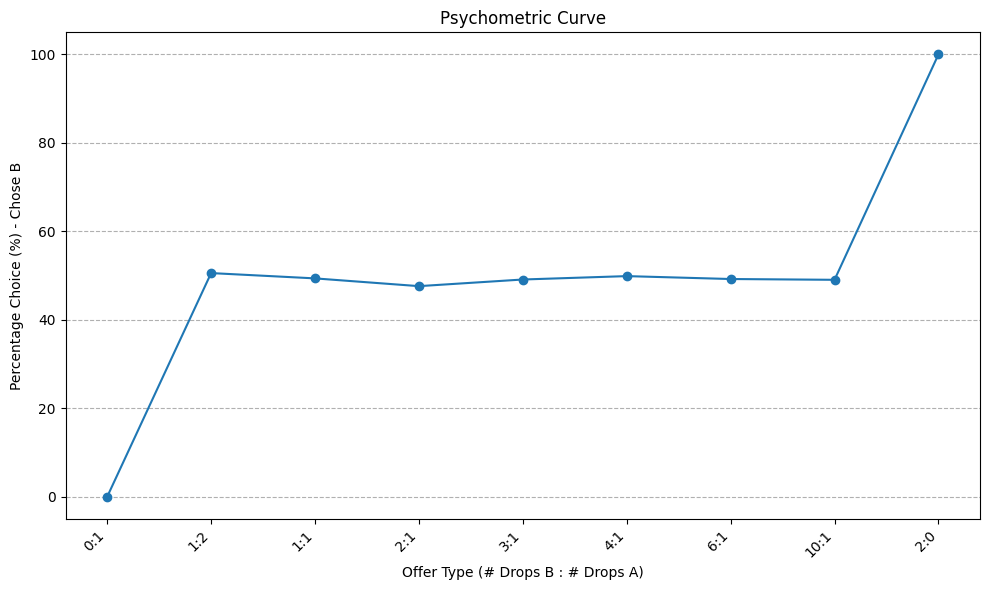

Closing the environment...
Environment closed.


In [2]:
# --- Imports ---
import os
import sys
import gymnasium as gym
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

# --- GPU Configuration ---
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# --- Add Modules directory to Python path ---
module_path = os.path.abspath(os.path.join('.', 'Modules'))

if module_path not in sys.path:
    sys.path.append(module_path)
    print(f"Added '{module_path}' to sys.path")
else:
    print(f"'{module_path}' already in sys.path")

# --- Import custom modules ---
from env_economic_choice_no_hold import EconomicChoiceEnv
from actor_critic_song import ActorCriticAgent
from reinforce_song import train_agent
from helper_functions import plot_metrics, plot_firing_rates, plot_psychometric_curve

# --- Set Random Seeds ---
seed_value = 2
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
random.seed(seed_value)

print("Setup Complete.")

# --- Training Configuration ---
config = {
    # Environment specific params
    "dt": 10,
    "A_to_B_ratio": 2.2,
    "reward_B": 1,
    "abort_penalty":-0.1,
    "input_noise_sigma": 0.0,
    "reward_fixation": 0.01,
    "reward_go_fixation": -0.01,
    "duration_params": [10, 10, 20, 20],

    # Agent architecture
    "actor_hidden_size": 50,
    "critic_hidden_size": 50,
    "actor_layers": 1,
    "critic_layers": 1,
    "layer_type": "GRU_modified",
    "actor_prob_connection": 0.1,
    "critic_prob_connection": 1.0,

    # Training hyperparameters
    "actor_lr": 4e-3,
    "critic_lr": 4e-3,
    "num_episodes": 35000,
    "gamma": 1.0,
    "l2_actor": 1e-4,
    "l2_critic": 1e-4,

    # Training process  
    "print_interval": 100,
    "record_history": 1
}

print("Configuration loaded:")
for key, value in config.items():
    print(f"  {key}: {value}")

# --- Environment Setup ---
print("Creating Padoa-Schioppa environment...")
env = EconomicChoiceEnv(
    dt=config["dt"],
    A_to_B_ratio=config["A_to_B_ratio"],
    reward_B=config["reward_B"],
    abort_penalty=config["abort_penalty"],
    input_noise_sigma=config["input_noise_sigma"],
    reward_fixation=config["reward_fixation"],
    reward_go_fixation=config["reward_go_fixation"],
    duration_params=config["duration_params"]
)

# Get observation and action space sizes from the actual environment instance
obs_size = env.observation_space.shape[0]
act_size = env.action_space.n
print(f"Observation size: {obs_size}, Action size: {act_size}")

initial_obs, initial_info = env.reset(seed=seed_value)
print(f"Environment reset. Initial info: {initial_info}")

# --- Agent Setup ---
print("Initializing Actor-Critic Agent...")
agent = ActorCriticAgent(
    obs_size=obs_size,
    act_size=act_size,
    actor_hidden_size=config["actor_hidden_size"],
    critic_hidden_size=config["critic_hidden_size"],
    actor_layers=config["actor_layers"],
    critic_layers=config["critic_layers"],
    actor_lr=config["actor_lr"],
    critic_lr=config["critic_lr"],
    actor_prob_connection=config["actor_prob_connection"],
    critic_prob_connection=config["critic_prob_connection"],
    layer_type=config["layer_type"]
)

print("Agent Initialized.")

# --- Training ---
print(f"Starting training for {config['num_episodes']} episodes...")

total_rewards_history, actor_loss_history, critic_loss_history, \
actor_firing_rates, critic_firing_rates,  measurements_juices = train_agent(
    env=env,
    agent=agent,
    num_episodes=config["num_episodes"],
    gamma=config["gamma"],
    print_interval=config["print_interval"],
    l2_actor=config["l2_actor"],
    l2_critic=config["l2_critic"],
    record_history=config["record_history"]
)

print("\nTraining finished.")

save_weights_path = "rnn_nohold/stage_2"
save_dir = os.path.dirname(save_weights_path)

# Create directory if it doesn't exist
if save_dir and not os.path.exists(save_dir):
    os.makedirs(save_dir, exist_ok=True)
    print(f"Created directory '{save_dir}'")
else:
    print(f"Directory '{save_dir}' already exists.")

# Save model
agent.save_full_models(save_weights_path)

# --- Plot Training Metrics ---
print("Plotting training metrics...")
# Adjust window sizes if needed based on num_episodes
plot_metrics(
    total_rewards_history,
    actor_loss_history,
    critic_loss_history,
    window_1=max(20, config["num_episodes"] // 50),
    window_2=max(50, config["num_episodes"] // 10)
)

print("Metrics plot displayed.")

# --- Plot Firing Rates ---
if actor_firing_rates is not None and critic_firing_rates is not None:
    print("Plotting neuron firing rates...")
    plot_firing_rates(actor_firing_rates, critic_firing_rates)
    print("Firing rate plot displayed.")
# Add checks for partial data as before...
elif actor_firing_rates is not None:
     print("Plotting only Actor firing rates (Critic might be Dense or logging failed)...")
     pass # Add specific plotting if desired
elif critic_firing_rates is not None:
     print("Plotting only Critic firing rates (Actor might be Dense or logging failed)...")
     pass # Add specific plotting if desired
else:
    print("Firing rate data not available (models might be Dense or logging was disabled/failed).")

# --- Plot psychometric curves ---
print("\n  Plotting Psychometric Curve for this stage...")
plot_psychometric_curve(measurements_juices, title=f"Psychometric Curve")

# --- Close the Environment ---
print("Closing the environment...")
env.close()
print("Environment closed.")

2025-05-13 20:45:20.316703: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747161923.947685     811 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747161925.028664     811 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747161934.960357     811 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747161934.960394     811 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747161934.960396     811 computation_placer.cc:177] computation placer alr

Added '/mnt/c/Users/imcir/Desktop/CIENCIA DATOS/Segundo cuatrimestre/TFM/Código/Modules' to sys.path
Setup Complete.
Configuration loaded:
  dt: 10
  A_to_B_ratio: 2.2
  reward_B: 1
  abort_penalty: -0.1
  input_noise_sigma: 0.0
  reward_fixation: 0.01
  reward_go_fixation: -0.01
  duration_params: [10, 10, 20, 20]
  actor_hidden_size: 50
  critic_hidden_size: 50
  actor_layers: 1
  critic_layers: 1
  layer_type: GRU_modified
  actor_prob_connection: 0.1
  critic_prob_connection: 1.0
  actor_lr: 0.004
  critic_lr: 0.004
  num_episodes: 46000
  gamma: 1.0
  l2_actor: 0.0001
  l2_critic: 0.0001
  print_interval: 100
  record_history: 1
Creating Padoa-Schioppa environment...
Observation size: 4, Action size: 3
Environment reset. Initial info: {'step': 0, 'epoch': 'fixation', 'juice_LR': ('A', 'B'), 'offer_BA': (1, 2), 'nL': 2, 'nR': 1, 'rL': 4.4, 'rR': 1.0, 'chosen_action': -1, 'choice_time_step': -1, 'is_correct_choice': None, 'A_to_B_ratio': 2.2, 'rewards_cfg': {'fix_step': 0.01, 'go_fi

2025-05-13 20:49:46.879289: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Agent Initialized.
Starting training for 46000 episodes...
Episode 100	Total Reward: -0.10	State [1. 0. 0. 0.]	Actor Loss: -0.0368	Critic Loss: 0.0011
Episode 200	Total Reward: -0.10	State [1. 0. 0. 0.]	Actor Loss: -0.0402	Critic Loss: 0.0010
Episode 300	Total Reward: -0.10	State [1. 0. 0. 0.]	Actor Loss: -0.0862	Critic Loss: 0.0031
Episode 400	Total Reward: -0.08	State [1.  1.  0.2 0. ]	Actor Loss: -0.1513	Critic Loss: 0.0218
Episode 500	Total Reward: 6.03	State [0.  1.  0.6 0.1]	Actor Loss: 3.9216	Critic Loss: 35.5342
Episode 600	Total Reward: -0.09	State [ 0.  -1.   0.   0.2]	Actor Loss: -0.1628	Critic Loss: 0.4014
Episode 700	Total Reward: 2.03	State [ 0.  -1.   0.1  0.2]	Actor Loss: 0.1757	Critic Loss: 1.3880
Episode 800	Total Reward: 2.22	State [0.  1.  0.6 0.1]	Actor Loss: -0.0218	Critic Loss: 0.7498
Episode 900	Total Reward: 0.02	State [ 0.  -1.   0.1  0. ]	Actor Loss: -1.4982	Critic Loss: 3.6237
Episode 1000	Total Reward: 2.23	State [0.  1.  0.6 0.1]	Actor Loss: 0.0098	Critic 

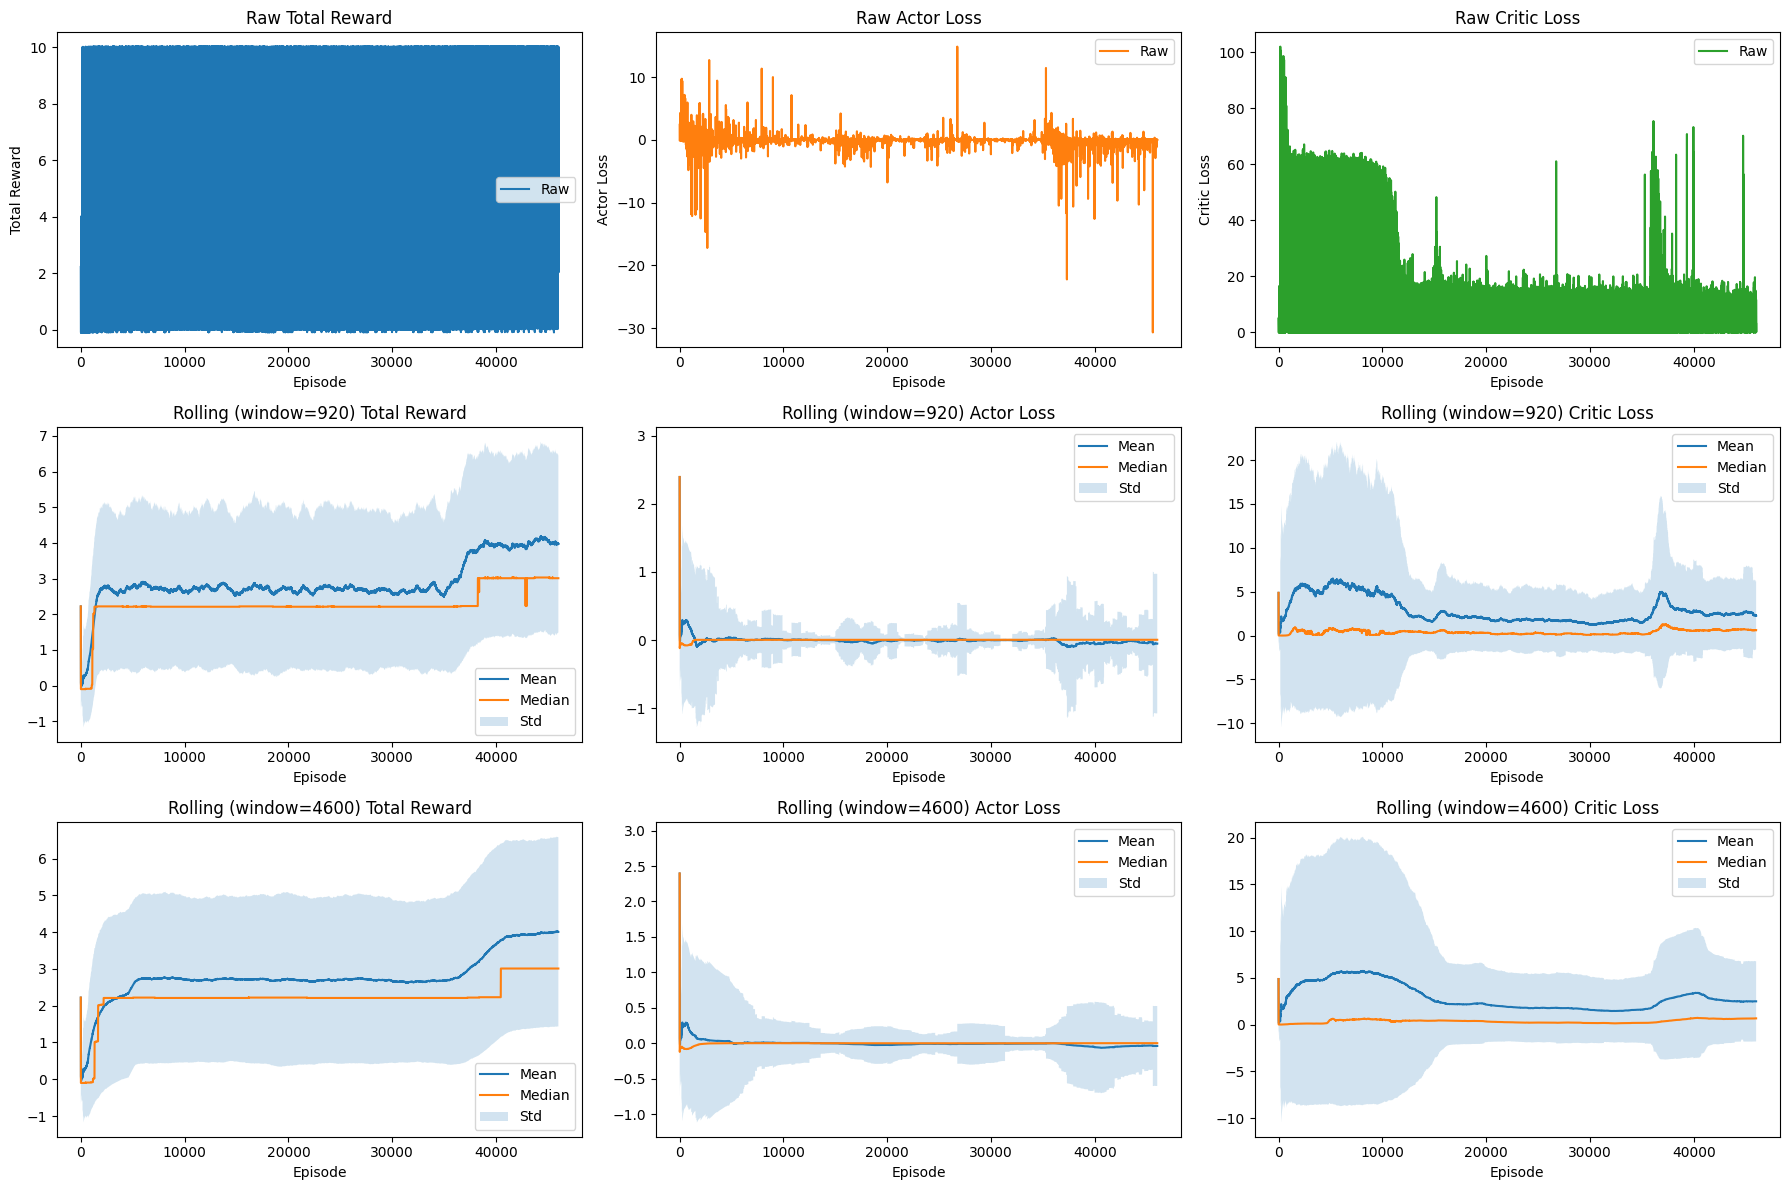

Metrics plot displayed.
Plotting neuron firing rates...


/mnt/c/Users/imcir/Desktop/CIENCIA DATOS/Segundo cuatrimestre/TFM/Código/Modules/helper_functions.py:102: RuntimeWarning: Mean of empty slice
  first_episode = np.nanmean(tensor[:, :, 0], axis=0)
/mnt/c/Users/imcir/Desktop/CIENCIA DATOS/Segundo cuatrimestre/TFM/Código/Modules/helper_functions.py:103: RuntimeWarning: Mean of empty slice
  last_episode = np.nanmean(tensor[:, :, -1], axis=0)


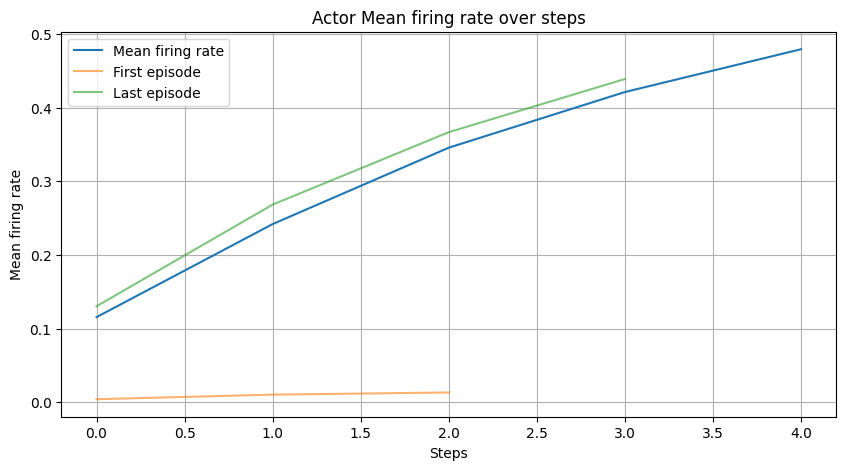

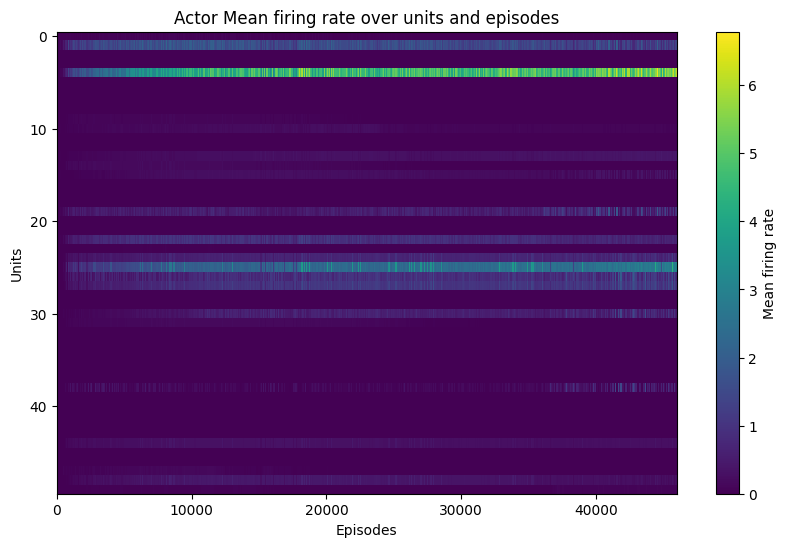

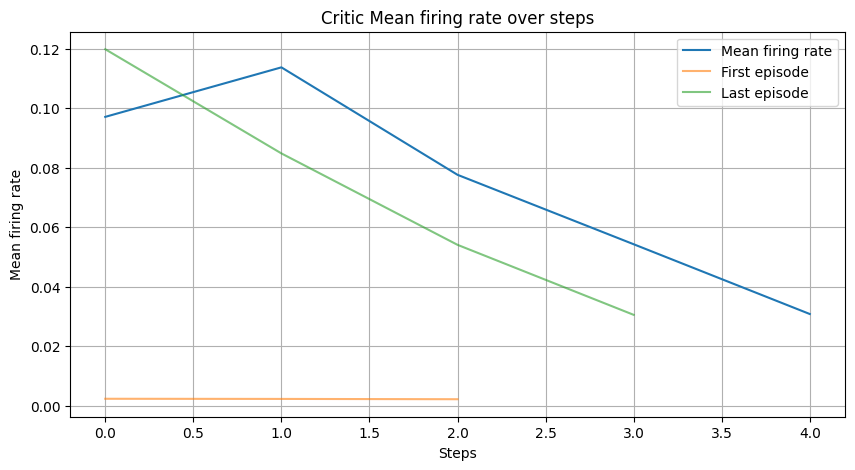

: 

In [ ]:
# --- Imports ---
import os
import sys
import gymnasium as gym
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

# --- GPU Configuration ---
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# --- Add Modules directory to Python path ---
module_path = os.path.abspath(os.path.join('.', 'Modules'))

if module_path not in sys.path:
    sys.path.append(module_path)
    print(f"Added '{module_path}' to sys.path")
else:
    print(f"'{module_path}' already in sys.path")

# --- Import custom modules ---
from env_economic_choice_no_hold import EconomicChoiceEnv
from actor_critic_song import ActorCriticAgent
from reinforce_song import train_agent
from helper_functions import plot_metrics, plot_firing_rates, plot_psychometric_curve

# --- Set Random Seeds ---
seed_value = 2
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
random.seed(seed_value)

print("Setup Complete.")

# --- Training Configuration ---
config = {
    # Environment specific params
    "dt": 10,
    "A_to_B_ratio": 2.2,
    "reward_B": 1,
    "abort_penalty":-0.1,
    "input_noise_sigma": 0.0,
    "reward_fixation": 0.01,
    "reward_go_fixation": -0.01,
    "duration_params": [10, 10, 20, 20],

    # Agent architecture
    "actor_hidden_size": 50,
    "critic_hidden_size": 50,
    "actor_layers": 1,
    "critic_layers": 1,
    "layer_type": "GRU_modified",
    "actor_prob_connection": 0.1,
    "critic_prob_connection": 1.0,

    # Training hyperparameters
    "actor_lr": 4e-3,
    "critic_lr": 4e-3,
    "num_episodes": 46000,
    "gamma": 1.0,
    "l2_actor": 1e-4,
    "l2_critic": 1e-4,

    # Training process  
    "print_interval": 100,
    "record_history": 1
}

print("Configuration loaded:")
for key, value in config.items():
    print(f"  {key}: {value}")

# --- Environment Setup ---
print("Creating Padoa-Schioppa environment...")
env = EconomicChoiceEnv(
    dt=config["dt"],
    A_to_B_ratio=config["A_to_B_ratio"],
    reward_B=config["reward_B"],
    abort_penalty=config["abort_penalty"],
    input_noise_sigma=config["input_noise_sigma"],
    reward_fixation=config["reward_fixation"],
    reward_go_fixation=config["reward_go_fixation"],
    duration_params=config["duration_params"]
)

# Get observation and action space sizes from the actual environment instance
obs_size = env.observation_space.shape[0]
act_size = env.action_space.n
print(f"Observation size: {obs_size}, Action size: {act_size}")

initial_obs, initial_info = env.reset(seed=seed_value)
print(f"Environment reset. Initial info: {initial_info}")

# --- Agent Setup ---
print("Initializing Actor-Critic Agent...")
agent = ActorCriticAgent(
    obs_size=obs_size,
    act_size=act_size,
    actor_hidden_size=config["actor_hidden_size"],
    critic_hidden_size=config["critic_hidden_size"],
    actor_layers=config["actor_layers"],
    critic_layers=config["critic_layers"],
    actor_lr=config["actor_lr"],
    critic_lr=config["critic_lr"],
    actor_prob_connection=config["actor_prob_connection"],
    critic_prob_connection=config["critic_prob_connection"],
    layer_type=config["layer_type"]
)

print("Agent Initialized.")

# --- Training ---
print(f"Starting training for {config['num_episodes']} episodes...")

total_rewards_history, actor_loss_history, critic_loss_history, \
actor_firing_rates, critic_firing_rates,  measurements_juices = train_agent(
    env=env,
    agent=agent,
    num_episodes=config["num_episodes"],
    gamma=config["gamma"],
    print_interval=config["print_interval"],
    l2_actor=config["l2_actor"],
    l2_critic=config["l2_critic"],
    record_history=config["record_history"]
)

print("\nTraining finished.")

save_weights_path = "rnn_nohold/stage_2"
save_dir = os.path.dirname(save_weights_path)

# Create directory if it doesn't exist
if save_dir and not os.path.exists(save_dir):
    os.makedirs(save_dir, exist_ok=True)
    print(f"Created directory '{save_dir}'")
else:
    print(f"Directory '{save_dir}' already exists.")

# Save model
agent.save_full_models(save_weights_path)

# --- Plot Training Metrics ---
print("Plotting training metrics...")
# Adjust window sizes if needed based on num_episodes
plot_metrics(
    total_rewards_history,
    actor_loss_history,
    critic_loss_history,
    window_1=max(20, config["num_episodes"] // 50),
    window_2=max(50, config["num_episodes"] // 10)
)

print("Metrics plot displayed.")

# --- Plot Firing Rates ---
if actor_firing_rates is not None and critic_firing_rates is not None:
    print("Plotting neuron firing rates...")
    plot_firing_rates(actor_firing_rates, critic_firing_rates)
    print("Firing rate plot displayed.")
# Add checks for partial data as before...
elif actor_firing_rates is not None:
     print("Plotting only Actor firing rates (Critic might be Dense or logging failed)...")
     pass # Add specific plotting if desired
elif critic_firing_rates is not None:
     print("Plotting only Critic firing rates (Actor might be Dense or logging failed)...")
     pass # Add specific plotting if desired
else:
    print("Firing rate data not available (models might be Dense or logging was disabled/failed).")

# --- Plot psychometric curves ---
print("\n  Plotting Psychometric Curve for this stage...")
plot_psychometric_curve(measurements_juices, title=f"Psychometric Curve")

# --- Close the Environment ---
print("Closing the environment...")
env.close()
print("Environment closed.")

2025-05-14 09:53:45.966940: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747209226.970383   15822 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747209227.225626   15822 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747209229.256244   15822 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747209229.256285   15822 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747209229.256287   15822 computation_placer.cc:177] computation placer alr

Added '/mnt/c/Users/imcir/Desktop/CIENCIA DATOS/Segundo cuatrimestre/TFM/Código/Modules' to sys.path
Setup Complete.
Configuration loaded:
  dt: 10
  A_to_B_ratio: 2.2
  reward_B: 1
  abort_penalty: -0.1
  input_noise_sigma: 0.0
  reward_fixation: 0.01
  reward_go_fixation: -0.01
  duration_params: [10, 10, 20, 20]
  actor_hidden_size: 50
  critic_hidden_size: 50
  actor_layers: 1
  critic_layers: 1
  layer_type: GRU_modified
  actor_prob_connection: 0.1
  critic_prob_connection: 1.0
  actor_lr: 0.004
  critic_lr: 0.004
  num_episodes: 42000
  gamma: 1.0
  l2_actor: 0.0001
  l2_critic: 0.0001
  print_interval: 100
  record_history: 1
Creating Padoa-Schioppa environment...
Observation size: 4, Action size: 3
Environment reset. Initial info: {'step': 0, 'epoch': 'fixation', 'juice_LR': ('A', 'B'), 'offer_BA': (1, 2), 'nL': 2, 'nR': 1, 'rL': 4.4, 'rR': 1.0, 'chosen_action': -1, 'choice_time_step': -1, 'is_correct_choice': None, 'A_to_B_ratio': 2.2, 'rewards_cfg': {'fix_step': 0.01, 'go_fi

2025-05-14 09:54:30.352514: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Agent Initialized.
Starting training for 42000 episodes...
Episode 100	Total Reward: -0.10	State [1. 0. 0. 0.]	Actor Loss: -0.0368	Critic Loss: 0.0011
Episode 200	Total Reward: -0.10	State [1. 0. 0. 0.]	Actor Loss: -0.0402	Critic Loss: 0.0010
Episode 300	Total Reward: -0.10	State [1. 0. 0. 0.]	Actor Loss: -0.0862	Critic Loss: 0.0031
Episode 400	Total Reward: -0.08	State [1.  1.  0.2 0. ]	Actor Loss: -0.1513	Critic Loss: 0.0218
Episode 500	Total Reward: 6.03	State [0.  1.  0.6 0.1]	Actor Loss: 3.9216	Critic Loss: 35.5342
Episode 600	Total Reward: -0.09	State [ 0.  -1.   0.   0.2]	Actor Loss: -0.1628	Critic Loss: 0.4014
Episode 700	Total Reward: 2.03	State [ 0.  -1.   0.1  0.2]	Actor Loss: 0.1757	Critic Loss: 1.3880
Episode 800	Total Reward: 2.22	State [0.  1.  0.6 0.1]	Actor Loss: -0.0218	Critic Loss: 0.7498
Episode 900	Total Reward: 0.02	State [ 0.  -1.   0.1  0. ]	Actor Loss: -1.4982	Critic Loss: 3.6237
Episode 1000	Total Reward: 2.23	State [0.  1.  0.6 0.1]	Actor Loss: 0.0098	Critic 

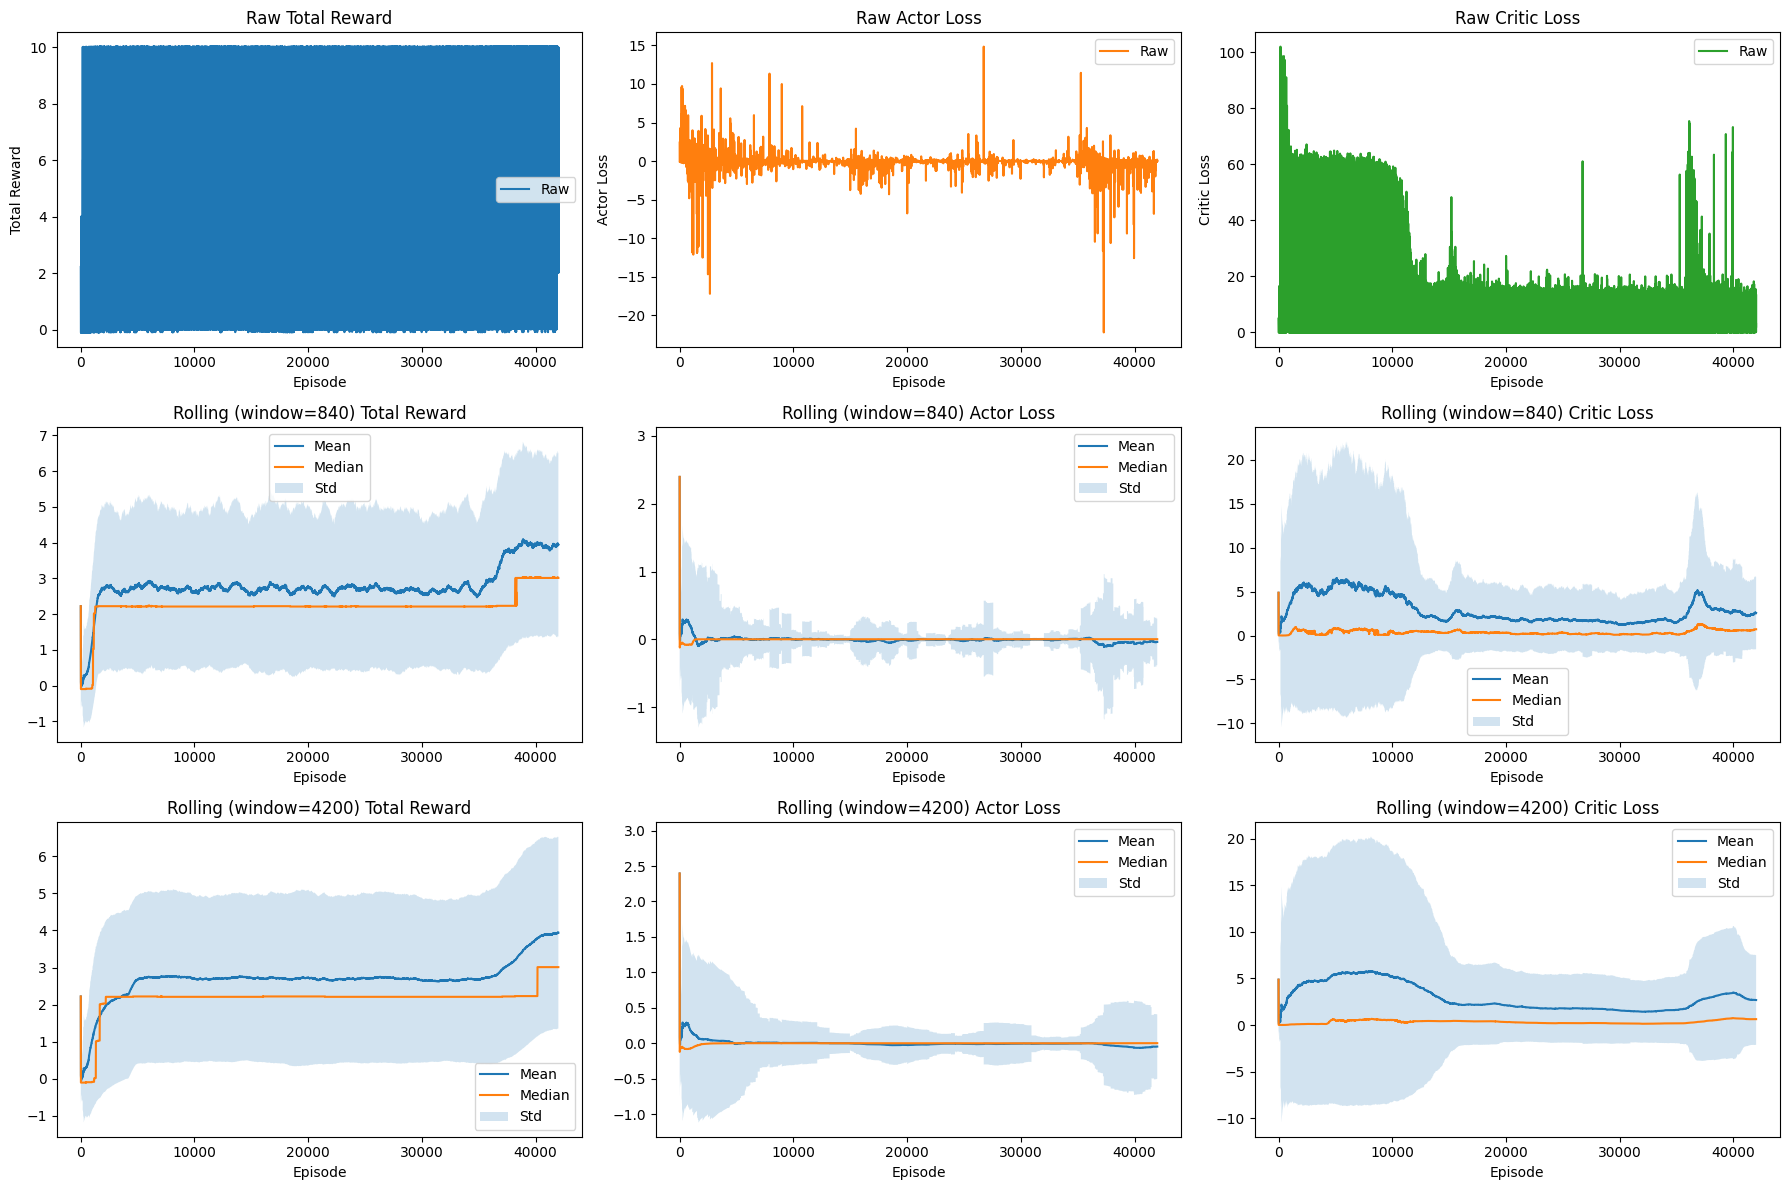

Metrics plot displayed.
Plotting neuron firing rates...


/mnt/c/Users/imcir/Desktop/CIENCIA DATOS/Segundo cuatrimestre/TFM/Código/Modules/helper_functions.py:102: RuntimeWarning: Mean of empty slice
  first_episode = np.nanmean(tensor[:, :, 0], axis=0)
/mnt/c/Users/imcir/Desktop/CIENCIA DATOS/Segundo cuatrimestre/TFM/Código/Modules/helper_functions.py:103: RuntimeWarning: Mean of empty slice
  last_episode = np.nanmean(tensor[:, :, -1], axis=0)


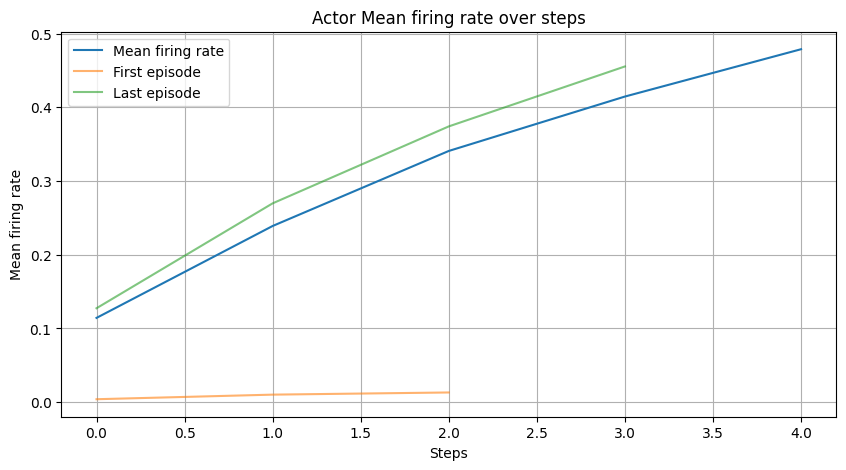

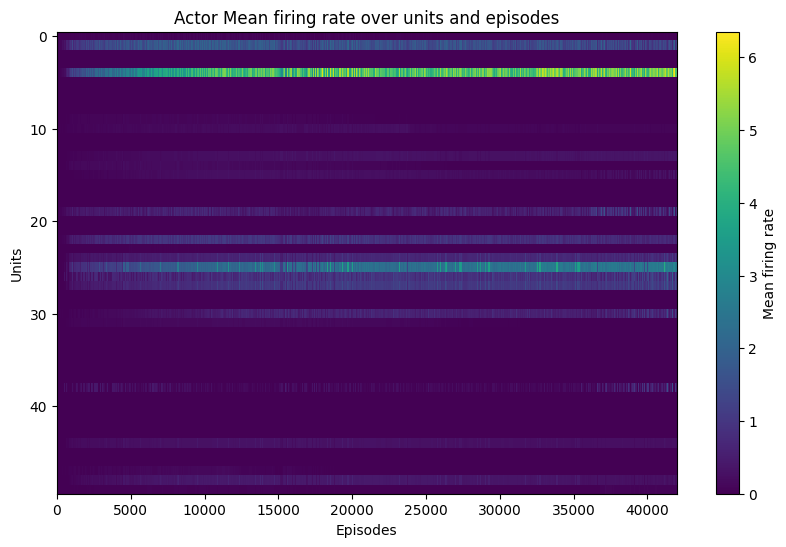

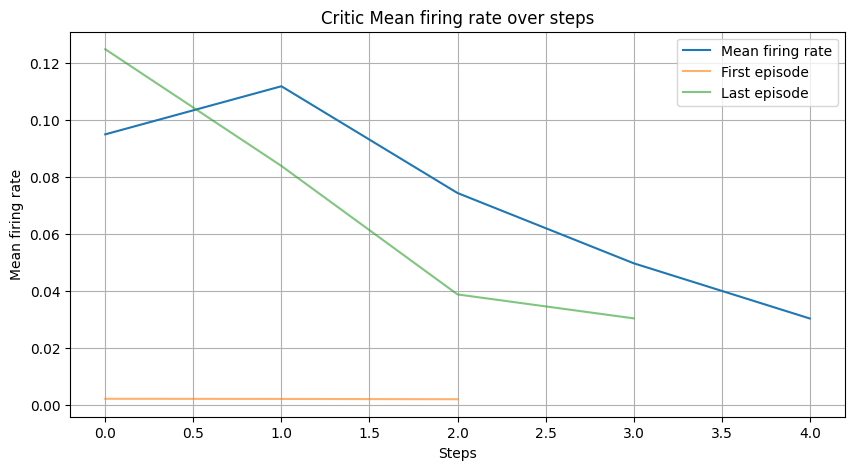

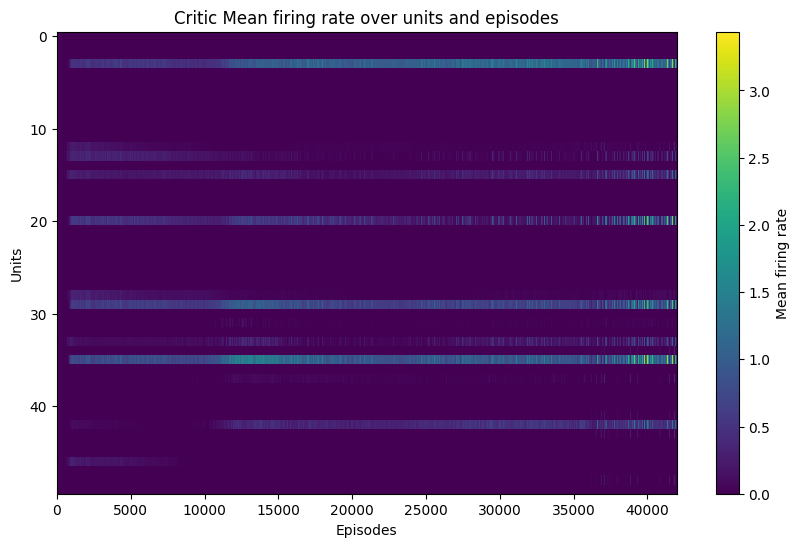

Firing rate plot displayed.

  Plotting Psychometric Curve for this stage...


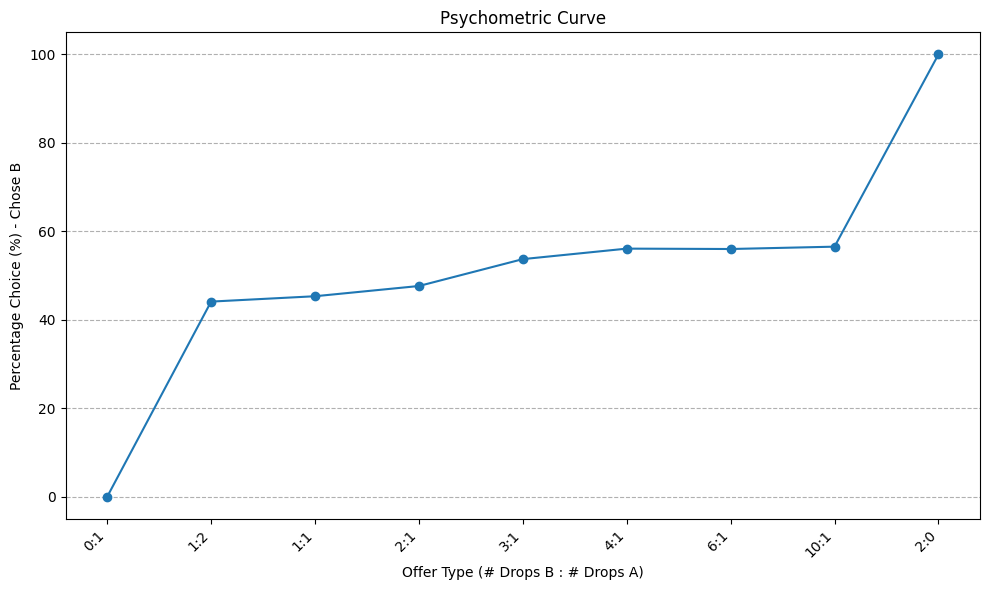

Closing the environment...
Environment closed.


In [1]:
# --- Imports ---
import os
import sys
import gymnasium as gym
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

# --- GPU Configuration ---
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# --- Add Modules directory to Python path ---
module_path = os.path.abspath(os.path.join('.', 'Modules'))

if module_path not in sys.path:
    sys.path.append(module_path)
    print(f"Added '{module_path}' to sys.path")
else:
    print(f"'{module_path}' already in sys.path")

# --- Import custom modules ---
from env_economic_choice_no_hold import EconomicChoiceEnv
from actor_critic_song import ActorCriticAgent
from reinforce_song import train_agent
from helper_functions import plot_metrics, plot_firing_rates, plot_psychometric_curve

# --- Set Random Seeds ---
seed_value = 2
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
random.seed(seed_value)

print("Setup Complete.")

# --- Training Configuration ---
config = {
    # Environment specific params
    "dt": 10,
    "A_to_B_ratio": 2.2,
    "reward_B": 1,
    "abort_penalty":-0.1,
    "input_noise_sigma": 0.0,
    "reward_fixation": 0.01,
    "reward_go_fixation": -0.01,
    "duration_params": [10, 10, 20, 20],

    # Agent architecture
    "actor_hidden_size": 50,
    "critic_hidden_size": 50,
    "actor_layers": 1,
    "critic_layers": 1,
    "layer_type": "GRU_modified",
    "actor_prob_connection": 0.1,
    "critic_prob_connection": 1.0,

    # Training hyperparameters
    "actor_lr": 4e-3,
    "critic_lr": 4e-3,
    "num_episodes": 42000,
    "gamma": 1.0,
    "l2_actor": 1e-4,
    "l2_critic": 1e-4,

    # Training process  
    "print_interval": 100,
    "record_history": 1
}

print("Configuration loaded:")
for key, value in config.items():
    print(f"  {key}: {value}")

# --- Environment Setup ---
print("Creating Padoa-Schioppa environment...")
env = EconomicChoiceEnv(
    dt=config["dt"],
    A_to_B_ratio=config["A_to_B_ratio"],
    reward_B=config["reward_B"],
    abort_penalty=config["abort_penalty"],
    input_noise_sigma=config["input_noise_sigma"],
    reward_fixation=config["reward_fixation"],
    reward_go_fixation=config["reward_go_fixation"],
    duration_params=config["duration_params"]
)

# Get observation and action space sizes from the actual environment instance
obs_size = env.observation_space.shape[0]
act_size = env.action_space.n
print(f"Observation size: {obs_size}, Action size: {act_size}")

initial_obs, initial_info = env.reset(seed=seed_value)
print(f"Environment reset. Initial info: {initial_info}")

# --- Agent Setup ---
print("Initializing Actor-Critic Agent...")
agent = ActorCriticAgent(
    obs_size=obs_size,
    act_size=act_size,
    actor_hidden_size=config["actor_hidden_size"],
    critic_hidden_size=config["critic_hidden_size"],
    actor_layers=config["actor_layers"],
    critic_layers=config["critic_layers"],
    actor_lr=config["actor_lr"],
    critic_lr=config["critic_lr"],
    actor_prob_connection=config["actor_prob_connection"],
    critic_prob_connection=config["critic_prob_connection"],
    layer_type=config["layer_type"]
)

print("Agent Initialized.")

# --- Training ---
print(f"Starting training for {config['num_episodes']} episodes...")

total_rewards_history, actor_loss_history, critic_loss_history, \
actor_firing_rates, critic_firing_rates,  measurements_juices = train_agent(
    env=env,
    agent=agent,
    num_episodes=config["num_episodes"],
    gamma=config["gamma"],
    print_interval=config["print_interval"],
    l2_actor=config["l2_actor"],
    l2_critic=config["l2_critic"],
    record_history=config["record_history"]
)

print("\nTraining finished.")

save_weights_path = "rnn_nohold/stage_2"
save_dir = os.path.dirname(save_weights_path)

# Create directory if it doesn't exist
if save_dir and not os.path.exists(save_dir):
    os.makedirs(save_dir, exist_ok=True)
    print(f"Created directory '{save_dir}'")
else:
    print(f"Directory '{save_dir}' already exists.")

# Save model
agent.save_full_models(save_weights_path)

# --- Plot Training Metrics ---
print("Plotting training metrics...")
# Adjust window sizes if needed based on num_episodes
plot_metrics(
    total_rewards_history,
    actor_loss_history,
    critic_loss_history,
    window_1=max(20, config["num_episodes"] // 50),
    window_2=max(50, config["num_episodes"] // 10)
)

print("Metrics plot displayed.")

# --- Plot Firing Rates ---
if actor_firing_rates is not None and critic_firing_rates is not None:
    print("Plotting neuron firing rates...")
    plot_firing_rates(actor_firing_rates, critic_firing_rates)
    print("Firing rate plot displayed.")
# Add checks for partial data as before...
elif actor_firing_rates is not None:
     print("Plotting only Actor firing rates (Critic might be Dense or logging failed)...")
     pass # Add specific plotting if desired
elif critic_firing_rates is not None:
     print("Plotting only Critic firing rates (Actor might be Dense or logging failed)...")
     pass # Add specific plotting if desired
else:
    print("Firing rate data not available (models might be Dense or logging was disabled/failed).")

# --- Plot psychometric curves ---
print("\n  Plotting Psychometric Curve for this stage...")
plot_psychometric_curve(measurements_juices, title=f"Psychometric Curve")

# --- Close the Environment ---
print("Closing the environment...")
env.close()
print("Environment closed.")

'/mnt/c/Users/imcir/Desktop/CIENCIA DATOS/Segundo cuatrimestre/TFM/Código/Modules' already in sys.path
Setup Complete.
Configuration loaded:
  dt: 10
  A_to_B_ratio: 2.2
  reward_B: 1
  abort_penalty: -0.1
  input_noise_sigma: 0.0
  reward_fixation: 0.01
  reward_go_fixation: -0.01
  duration_params: [10, 10, 20, 20]
  actor_hidden_size: 50
  critic_hidden_size: 50
  actor_layers: 1
  critic_layers: 1
  layer_type: GRU_modified
  actor_prob_connection: 0.1
  critic_prob_connection: 1.0
  actor_lr: 0.004
  critic_lr: 0.004
  num_episodes: 42000
  gamma: 1.0
  l2_actor: 0.0001
  l2_critic: 0.0001
  print_interval: 100
  record_history: 1
Creating Padoa-Schioppa environment...
Observation size: 4, Action size: 3
Environment reset. Initial info: {'step': 0, 'epoch': 'fixation', 'juice_LR': ('A', 'B'), 'offer_BA': (2, 0), 'nL': 0, 'nR': 2, 'rL': 0.0, 'rR': 2.0, 'chosen_action': -1, 'choice_time_step': -1, 'is_correct_choice': None, 'A_to_B_ratio': 2.2, 'rewards_cfg': {'fix_step': 0.01, 'go_

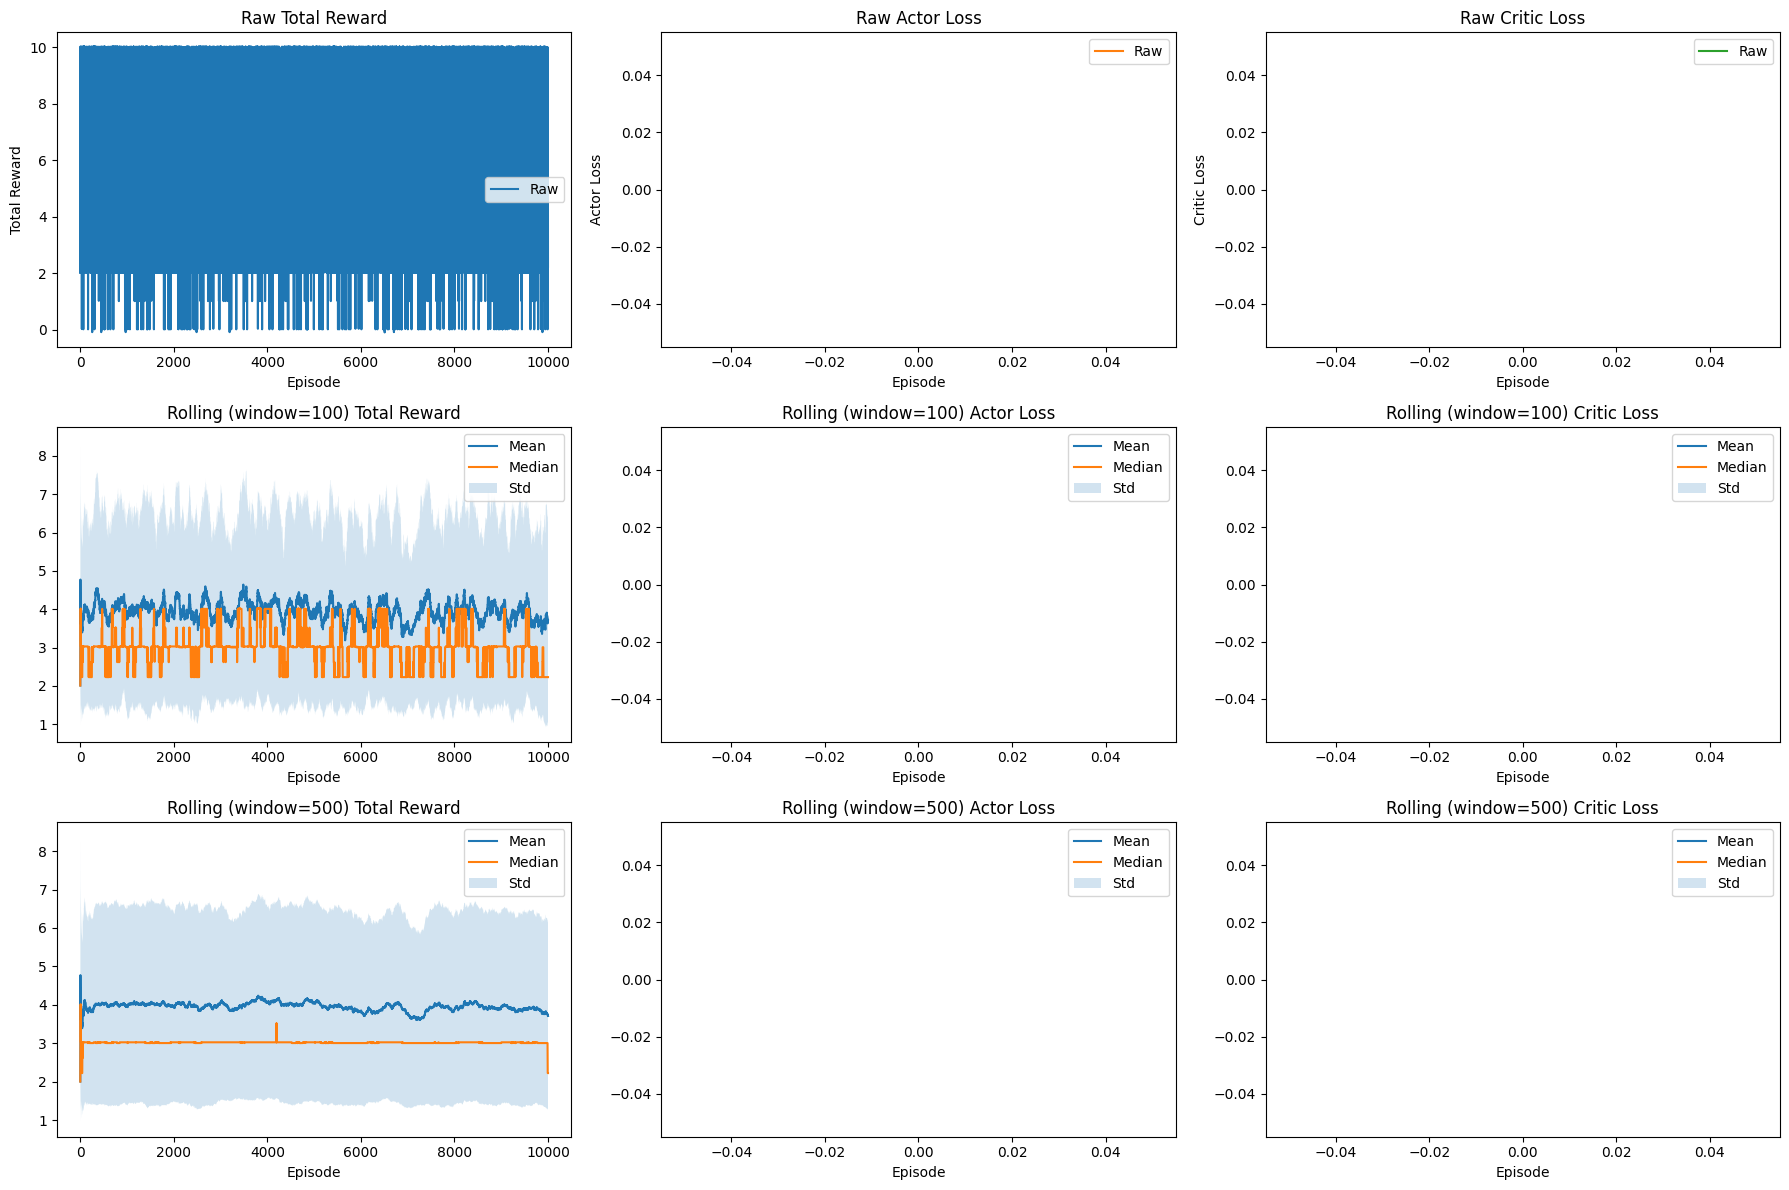

/mnt/c/Users/imcir/Desktop/CIENCIA DATOS/Segundo cuatrimestre/TFM/Código/Modules/helper_functions.py:102: RuntimeWarning: Mean of empty slice
  first_episode = np.nanmean(tensor[:, :, 0], axis=0)
/mnt/c/Users/imcir/Desktop/CIENCIA DATOS/Segundo cuatrimestre/TFM/Código/Modules/helper_functions.py:103: RuntimeWarning: Mean of empty slice
  last_episode = np.nanmean(tensor[:, :, -1], axis=0)


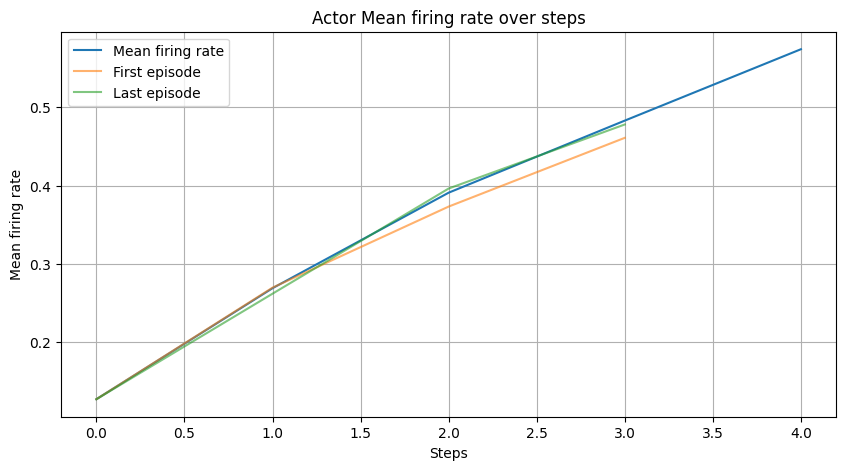

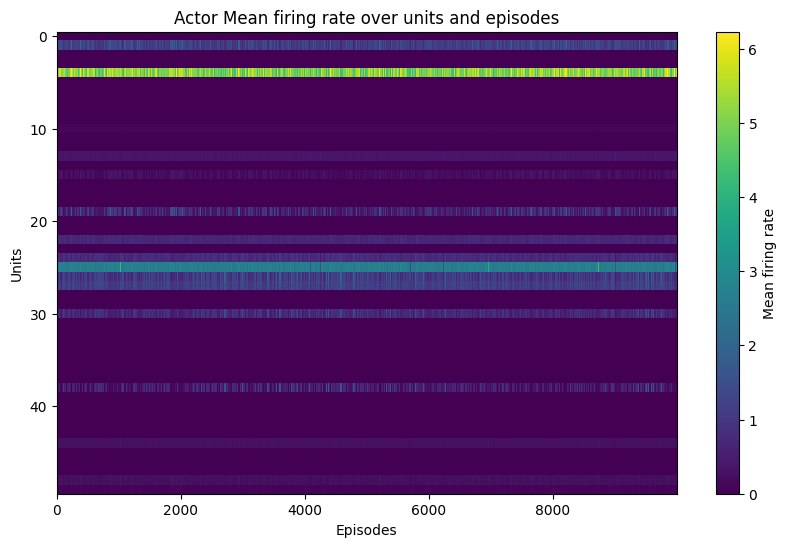

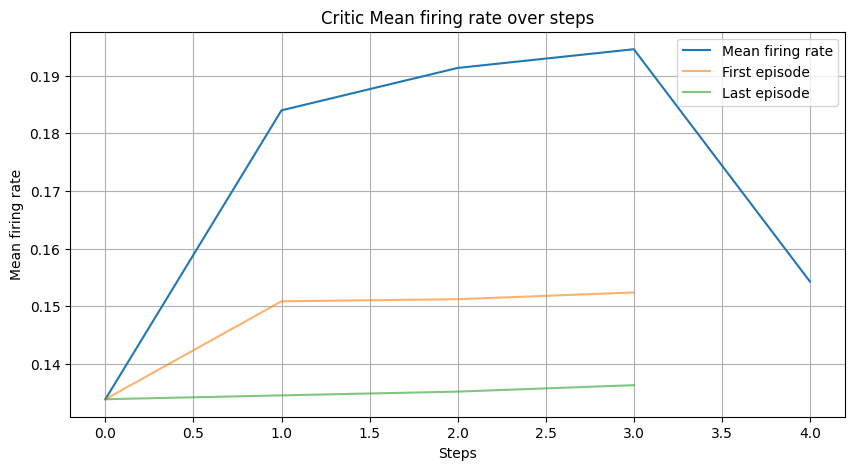

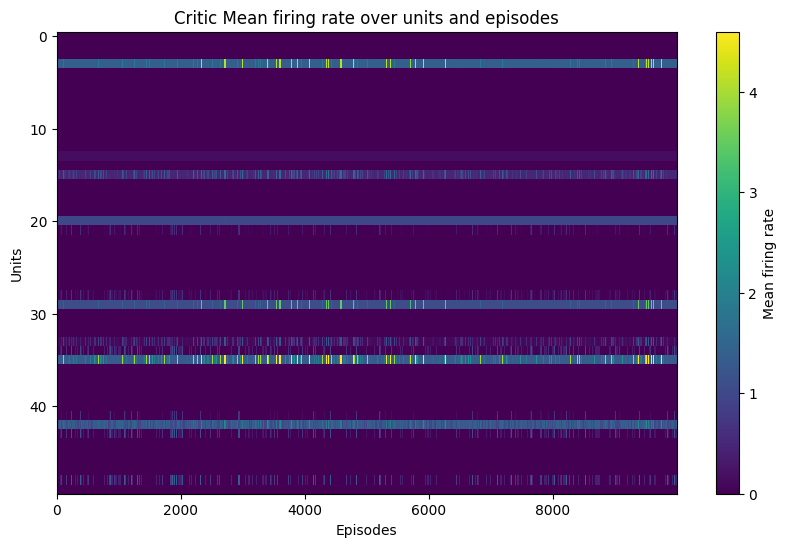

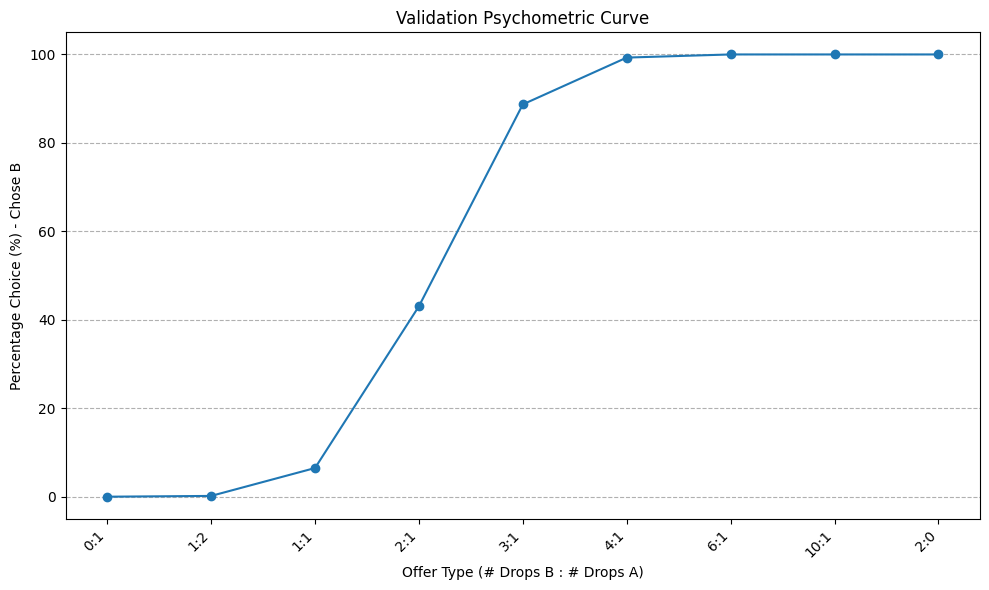

In [2]:
# --- Imports ---
import os
import sys
import gymnasium as gym
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

# --- GPU Configuration ---
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# --- Add Modules directory to Python path ---
module_path = os.path.abspath(os.path.join('.', 'Modules'))

if module_path not in sys.path:
    sys.path.append(module_path)
    print(f"Added '{module_path}' to sys.path")
else:
    print(f"'{module_path}' already in sys.path")

# --- Import custom modules ---
from env_economic_choice_no_hold import EconomicChoiceEnv
from actor_critic_song import ActorCriticAgent
from helper_functions import plot_metrics, plot_firing_rates, plot_psychometric_curve, collect_other_measurements, pad_hidden_states

# --- Set Random Seeds ---
seed_value = 3
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
random.seed(seed_value)

print("Setup Complete.")

# --- Validation Configuration ---
config = {
    # Environment specific params
    "dt": 10,
    "A_to_B_ratio": 2.2,
    "reward_B": 1,
    "abort_penalty":-0.1,
    "input_noise_sigma": 0.0,
    "reward_fixation": 0.01,
    "reward_go_fixation": -0.01,
    "duration_params": [10, 10, 20, 20],

    # Agent architecture
    "actor_hidden_size": 50,
    "critic_hidden_size": 50,
    "actor_layers": 1,
    "critic_layers": 1,
    "layer_type": "GRU_modified",
    "actor_prob_connection": 0.1,
    "critic_prob_connection": 1.0,

    # Training hyperparameters
    "actor_lr": 4e-3,
    "critic_lr": 4e-3,
    "num_episodes": 42000,
    "gamma": 1.0,
    "l2_actor": 1e-4,
    "l2_critic": 1e-4,

    # Training process  
    "print_interval": 100,
    "record_history": 1
}

print("Configuration loaded:")
for key, value in config.items():
    print(f"  {key}: {value}")

# --- Environment Setup ---
print("Creating Padoa-Schioppa environment...")
env = EconomicChoiceEnv(
    dt=config["dt"],
    A_to_B_ratio=config["A_to_B_ratio"],
    reward_B=config["reward_B"],
    abort_penalty=config["abort_penalty"],
    input_noise_sigma=config["input_noise_sigma"],
    reward_fixation=config["reward_fixation"],
    reward_go_fixation=config["reward_go_fixation"],
    duration_params=config["duration_params"]
)

# Get observation and action space sizes from the actual environment instance
obs_size = env.observation_space.shape[0]
act_size = env.action_space.n
print(f"Observation size: {obs_size}, Action size: {act_size}")

initial_obs, initial_info = env.reset(seed=seed_value)
print(f"Environment reset. Initial info: {initial_info}")

# --- Agent Setup ---
print("Initializing Actor-Critic Agent...")
agent = ActorCriticAgent(
    obs_size=obs_size,
    act_size=act_size,
    actor_hidden_size=config["actor_hidden_size"],
    critic_hidden_size=config["critic_hidden_size"],
    actor_layers=config["actor_layers"],
    critic_layers=config["critic_layers"],
    actor_lr=config["actor_lr"],
    critic_lr=config["critic_lr"],
    actor_prob_connection=config["actor_prob_connection"],
    critic_prob_connection=config["critic_prob_connection"],
    layer_type=config["layer_type"]
)

agent.load_full_models("rnn_nohold/stage_2") 

print("Agent Initialized.")

# --- Validation ---
num_episodes = 10000
total_rewards_history = []
actor_loss_history  = []
critic_loss_history = []
actor_states_all   = []
critic_states_all  = []
other_measures     = []

print(f"\nRunning {num_episodes} validation episodes…")
for ep in range(num_episodes):
    state, _ = env.reset(seed=seed_value + ep)
    done = False
    ep_reward = 0.0

    # per‐episode buffers
    actor_hidden = None
    critic_hidden = None
    actor_h_ep = []
    critic_h_ep = []
    prev_action = None

    while not done:
        # select action in eval mode
        action, _, new_actor_hidden = agent.select_action(
            state, actor_hidden_states=actor_hidden, training=False
        )
        # record actor hidden state
        actor_h_ep.append(new_actor_hidden[0].numpy().flatten())
        actor_hidden = new_actor_hidden

        # build prev_action one‐hot for critic eval
        prev_a_oh = np.zeros(act_size, dtype=np.float32)
        if prev_action is not None:
            prev_a_oh[prev_action] = 1.0

        # critic hidden/state
        value, new_critic_hidden = agent.evaluate_critic_step(
            actor_h_ep[-1], prev_a_oh, critic_hidden_states=critic_hidden, training=False
        )
        critic_h_ep.append(new_critic_hidden[0].numpy().flatten())
        critic_hidden = new_critic_hidden

        # step environment
        state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        ep_reward += reward
        prev_action = action

    # episode done → record
    total_rewards_history.append(ep_reward)
    actor_loss_history.append(np.nan)
    critic_loss_history.append(np.nan)

    # turn list of (steps×units) into array units×steps
    actor_states_all.append(np.array(actor_h_ep).T)
    critic_states_all.append(np.array(critic_h_ep).T)

    # collect the same “other measurements” you used in training
    other_measures.append(collect_other_measurements(env, done, reward))

    if (ep+1) % 1000 == 0:
        print(f"  Episode {ep+1}/{num_episodes}  reward={ep_reward:.2f}")

env.close()
print("Validation complete.\n")

# --- prepare firing‐rate tensors just like in train_agent ---
# actor
if actor_states_all:
    max_steps_a = max(s.shape[1] for s in actor_states_all)
    units_a    = actor_states_all[0].shape[0]
    a_padded   = [pad_hidden_states(s, max_steps_a, units_a) for s in actor_states_all]
    actor_states_tensor = np.transpose(np.array(a_padded), (1,2,0))
else:
    actor_states_tensor = None

# critic
if critic_states_all:
    max_steps_c = max(s.shape[1] for s in critic_states_all)
    units_c    = critic_states_all[0].shape[0]
    c_padded   = [pad_hidden_states(s, max_steps_c, units_c) for s in critic_states_all]
    critic_states_tensor = np.transpose(np.array(c_padded), (1,2,0))
else:
    critic_states_tensor = None

# --- and now your helper‐function plots! ---
plot_metrics(
    total_rewards_history,
    actor_loss_history,
    critic_loss_history,
    window_1=100,
    window_2=500
)

plot_firing_rates(actor_states_tensor, critic_states_tensor)

plot_psychometric_curve(other_measures, title="Validation Psychometric Curve")